In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 512
div = 1

nSimTime = nLat*10
#import_time_list = np.asarray(np.arange(2*nLat).tolist() + np.arange(nSimTime-2*nLat,nSimTime).tolist())
#import_time_list = np.asarray(np.arange(nLat).tolist() + np.arange(nSimTime-nLat,nSimTime).tolist())
#import_time_list = np.arange(nSimTime-nLat,nSimTime)
import_time_list = np.arange(nSimTime-nLat//2,nSimTime)
nTime = len(import_time_list)
nSims = 500

phi0 = 1.
m2bare = 1.
lamb = 1.
lenLat = 100.;
phi_initial = 0
nCols = 3

nyq = nLat//2
spec = nyq

alpha = 8
step = 1
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha*step

### Theoretical Field PS 

In [4]:
sim_location_null = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_null_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_location_fldk0 = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_fldk0_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_location_momk0 = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_momk0_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'

def extract_sim_null(nT, nL, tem, phi, lam, m2, gam, sim):
    data = np.genfromtxt(sim_location_null(nT, nL, tem, phi, lam, m2, gam, sim))
    return np.asarray([np.reshape(data[:,col], (nT, nL))[import_time_list] for col in range(nCols)])

def extract_sim_fldk0(nT, nL, tem, phi, lam, m2, gam, sim):
    data = np.genfromtxt(sim_location_fldk0(nT, nL, tem, phi, lam, m2, gam, sim))
    return np.asarray([np.reshape(data[:,col], (nT, nL))[import_time_list]  for col in range(nCols)])

def extract_sim_momk0(nT, nL, tem, phi, lam, m2, gam, sim):
    data = np.genfromtxt(sim_location_momk0(nT, nL, tem, phi, lam, m2, gam, sim))
    return np.asarray([np.reshape(data[:,col], (nT, nL))[import_time_list]  for col in range(nCols)])

In [5]:
norm = 1./ phi0 / np.sqrt(2.*lenLat)
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2.*np.pi
freqs_in_t = np.fft.fftshift(np.fft.fftfreq(nTime, d=dtout))*2.*np.pi
omegasq = freqs**2. + m2bare

spectral_field = lambda tem: np.asarray([norm * np.sqrt(2./(np.exp(omegasq[k]**0.5/tem) - 1.)) / omegasq[k]**0.25 if k != nLat//2 else 0. for k in range(nLat)])
sigma0sq_th = lambda tem: np.sum( np.abs(spectral_field(tem))**2. )

V = lambda x: - 0.5*m2bare*x**2. + lamb * x**4. / 24.
th_masses = lambda tem: -m2bare + 0.5*lamb*sigma0sq_th(tem)

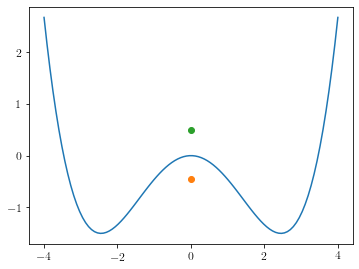

In [6]:
plt.plot(np.linspace(-4,4,100), V(np.linspace(-4,4,100)))
plt.plot(0.5 * 0.**2. + V(div), 'o')
plt.plot(0.5 * div**2. + V(0.), 'o')

### Extract data from files

In [7]:
list_gamma = [0]
list_temp = np.arange(9, 16, 2)[1::]; print(list_temp)
fine_temp_list = np.linspace(min(list_temp), max(list_temp), 100)

[11 13 15]


In [8]:
all_data_null = np.asarray([[[extract_sim_null(nSimTime, nLat, temp, phi0, lamb, m2bare, gamma, sim) for sim in range(nSims)] for gamma in list_gamma] for temp in list_temp])
print('Done')

all_data_fldk0 = np.asarray([[[extract_sim_fldk0(nSimTime, nLat, temp, phi0, lamb, m2bare, gamma, sim) for sim in range(nSims)] for gamma in list_gamma] for temp in list_temp])
print('Done')

all_data_momk0 = np.asarray([[[extract_sim_momk0(nSimTime, nLat, temp, phi0, lamb, m2bare, gamma, sim) for sim in range(nSims)] for gamma in list_gamma] for temp in list_temp])
print('Done')

Done
Done
Done


In [9]:
all_data = [all_data_null, all_data_fldk0, all_data_momk0]
list_titles = ['null', r'$\phi(k=0)$ boost', r'$\partial_t \phi(k=0)$ boost']

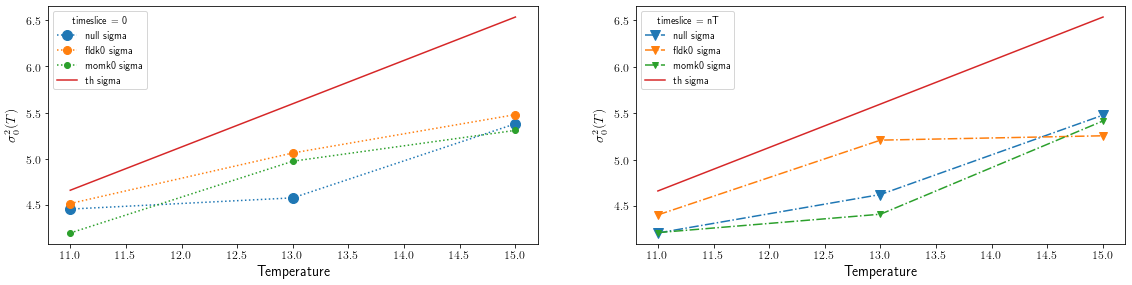

In [10]:
# check power spectrum and sigma0 match
if True:
    fig, ax = plt.subplots(1, 2, figsize = (20, 4))
    list_titles = ['null', 'fldk0', 'momk0']
    psmean_at0, sigma_at0, psmean_atnT, sigma_atnT = [], [], [], []
    for ind in range(len(all_data)):
        time = 0
        sigma_at0.append([np.mean([all_data[ind][ttt][0][sim][0][time]**2. for sim in range(nSims)]) for ttt in range(len(list_temp))])
        time = nTime-1
        sigma_atnT.append([np.mean([all_data[ind][ttt][0][sim][0][time]**2. for sim in range(nSims)]) for ttt in range(len(list_temp))])

        ax[0].plot(list_temp, sigma_at0[ind], marker='o', ms=10-ind*2, ls=':', label=list_titles[ind]+' sigma')
        ax[1].plot(list_temp, sigma_atnT[ind], marker='v', ms=10-ind*2, ls='-.', label=list_titles[ind]+' sigma')
        
    for aaa, axis in enumerate(ax):
        axis.plot(list_temp, sigma0sq_th(list_temp), label='th sigma')
        axis.set_xlabel('Temperature')
        axis.set_ylabel(r'$\sigma_0^2(T)$')
        axis.legend(title='timeslice = '+(str(0) if aaa==0 else 'nT'))
    plt.show()

In [11]:
# Plot one realisation at each temperature
if False:
    sim = random.randint(0, nSims-1)
    gamma = 0
    col = 0

    fig, ax = plt.subplots(len(all_data), len(list_temp), figsize = (4*len(list_temp)+4, 10))
    for iii in range(len(all_data)):
        for tt, temp in enumerate(list_temp):
            im0 = ax[iii][tt].imshow(all_data[iii][tt][gamma][sim][col], aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im0, ax = ax[iii][tt])
            ax[iii][tt].set_title('T = '+str(temp)+f', $\gamma$ = '+str(list_gamma[gamma]))
    plt.suptitle('Simulation '+str(sim)+f', first row: null; second row: $\phi(k=0)$ boost; third row: $\partial_t \phi(k=0)$ boost')
    plt.show()

In [12]:
# Pick a temperature and plot all simulations
if False:
    temp = 0
    gamma = 0
    sims_per_col = 25

    list_sims = np.arange(0, nSims, 1)

    for iii in range(len(all_data)):
        fig, ax = plt.subplots(int(np.ceil(len(list_sims)/sims_per_col)), sims_per_col, figsize = (sims_per_col*4, 4.*(len(list_sims)+1)//sims_per_col))
        io = -1
        for sim in range(len(list_sims)):
            simulation = list_sims[sim]
            if sim % sims_per_col == 0: io += 1
            im0 = ax[io][sim%sims_per_col].imshow(all_data[iii][temp][gamma][simulation][0], aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im0, ax = ax[io][sim%sims_per_col])
            ax[io][sim%sims_per_col].set_title('sim = '+str(simulation))
        plt.suptitle('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]), weight=10, size='xx-large', y=1)
        plt.tight_layout(); plt.show()

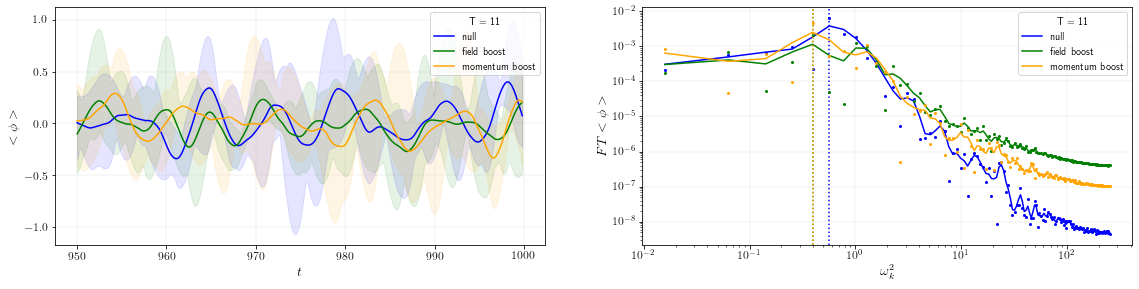

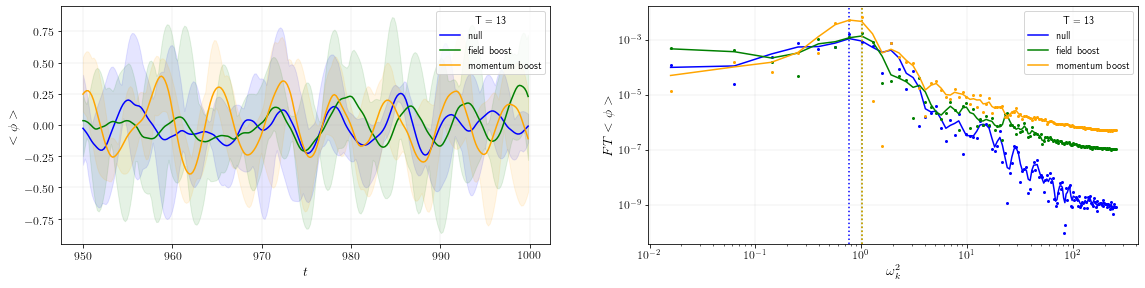

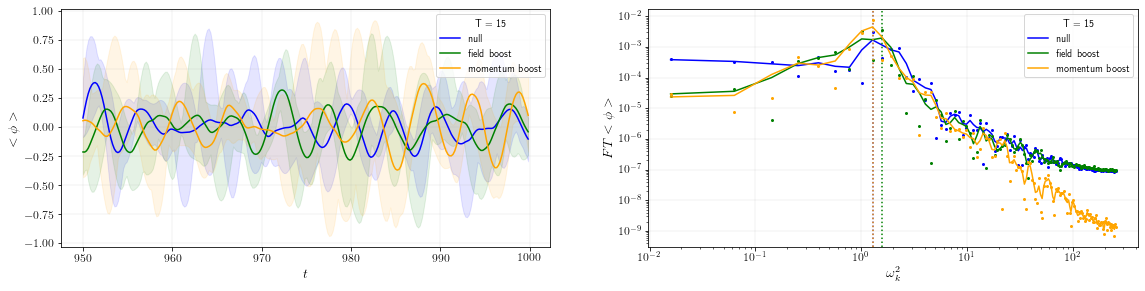

In [20]:
# Show mean field evolution with time of ensemble average
if True:
    null_m2_mnfld, fldk0_m2_mnfld, momk0_m2_mnfld = [], [], []
    data_mass_mnfld = [null_m2_mnfld, fldk0_m2_mnfld, momk0_m2_mnfld]
    time_list = np.arange(nTime)
    
    for ggg, gamma in enumerate(list_gamma):
        list_titles = ['null', 'field boost', 'momentum boost']
        for ttt, temp in enumerate(list_temp):
            fig, ax = plt.subplots(1, 2, figsize = (20, 4))
            list_ls = ['-', '--', ':']
            colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
            for ind, data in enumerate(all_data):
                col = next(colors)
                meanFld1 = np.max([np.mean(all_data[ind][ttt][ggg][sim,0], axis=1) for sim in range(nSims)], axis=0)
                meanFld2 = np.min([np.mean(all_data[ind][ttt][ggg][sim,0], axis=1) for sim in range(nSims)], axis=0)
                ax[0].fill_between(import_time_list*dtout, meanFld1, meanFld2, color=col, alpha=0.1)

                meanFld = [np.mean(all_data[ind][ttt][ggg][:,0,time]) for time in time_list]
                ax[0].plot(import_time_list*dtout, meanFld, color=col, label=list_titles[ind])
#                ax[0].axvline(import_time_list[0]*dtout, color='darkgray', ls=':')

                pos_Tfreqs = np.fft.fftshift(np.fft.fftfreq(len(time_list), d=dtout))*2.*np.pi
                meanFld = [np.mean(all_data[ind][ttt][ggg][:,0,time]) for time in time_list]
                pspecMeanFld = np.abs(np.fft.fftshift(np.fft.ifft(meanFld)))[pos_Tfreqs>0]**2.

                pos_Tfreqs = pos_Tfreqs[pos_Tfreqs>0]
                ax[1].plot(pos_Tfreqs**2., pspecMeanFld, color=col, marker='o', ms=2, linestyle='None')
                ax[1].plot(pos_Tfreqs**2., gaussian_filter1d(pspecMeanFld, sigma=0.8), color=col, label=list_titles[ind])
                # this takes frequency of maximum 
                data_mass_mnfld[ind].append(pos_Tfreqs[pspecMeanFld.tolist().index(np.max(pspecMeanFld))]**2.)
                ax[1].axvline(data_mass_mnfld[ind][-1], color=col, linestyle=':')
                
            ax[0].set_xlabel(r'$t$')
            ax[0].set_ylabel(r'$<\phi>$')
            ax[1].set_xlabel(r'$\omega_k^2$')
            ax[1].set_ylabel(r'$FT <\phi>$')
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
            for axx in ax:
                axx.legend(title='T = '+str(temp))
                axx.grid(color='darkgray', linewidth=0.2, linestyle='--')

#            plt.tight_layout()
            plt.show()

In [31]:
# mass from equilibrium condition
if False:
    null_m2_equil, fldk0_m2_equil, momk0_m2_equil = [], [], []
    gam = 0

    fig, ax = plt.subplots(3, len(all_data), figsize = (20, 10))
    for masses_sq, iii in zip([null_m2_equil, fldk0_m2_equil, momk0_m2_equil], range(len(all_data))):
        time_list = np.arange(nTime//2, nTime)
        colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
        for tt, temp in enumerate(list_temp):
            col = next(colors)

# for a pure harmonic oscillator, there is no gradient energy, this approximation should work in the high T limit we are working
# compute frequency of oscillation of said oscillator:
            # total energy at t=0
            # total energy if SHO at t = 0.5*p^2 + 0.5*omega^2*phi^2
            energy0 = np.mean(0.5*all_data[iii][tt][gam][:,1,0]**2. + V(all_data[iii][tt][gam][:,0,0]))
            energyt = np.asarray([np.mean(0.5*all_data[iii][tt][gam][:,1,time]**2.) for time in time_list])
            omegasq_osc = (energy0-energyt)
            # this is the difference in initial total energy and later time kinetic energy;
            #at late time all energy is kinetic + harmonic potential;
            #therefore this difference is all harmonic potential energy in time
            # fourier transform to get frequencies
            # k is already zero because we averaged across the lattice

#            ax[0][iii].plot(time_list, [np.mean(0.5*all_data[iii][tt][gam][:,1,time]**2.+all_data[iii][tt][gam][:,2,time]+V(all_data[iii][tt][gam][:,0,time])) for time in time_list], alpha=1, color=col, label='total, T = '+str(temp))
#            ax[0][iii].plot(time_list, [np.mean(0.5*all_data[iii][tt][gam][:,1,time]**2.+all_data[iii][tt][gam][:,2,time]) for time in time_list], alpha=1, color=col, label='total, T = '+str(temp))
            ax[0][iii].plot(time_list, [np.mean(0.5*all_data[iii][tt][gam][:,1,time]**2.) for time in time_list], alpha=1, color=col, label='kinetic, T = '+str(temp), marker='o', ms=1)
            ax[0][iii].plot(time_list, [np.mean(all_data[iii][tt][gam][:,2,time]) for time in time_list], alpha=0.6, color=col, label='gradient, T = '+str(temp))
            ax[0][iii].plot(time_list, [np.mean(V(all_data[iii][tt][gam][:,0,time])) for time in time_list],  alpha=0.2, color=col, label='potential, T = '+str(temp))

            oo = np.fft.fftshift(np.fft.fftfreq(len(omegasq_osc), d=dtout))*2.*np.pi
            fft_omegasq_osc = np.abs(np.fft.fftshift(np.fft.ifft(omegasq_osc)))**2.
            fft_omegasq_osc[oo<=0.] = 0.
            masses_sq.append(oo[fft_omegasq_osc==np.max(fft_omegasq_osc)][0])
            ax[1][iii].plot(oo[oo>=0], fft_omegasq_osc[oo>=0], color=col, label='T = '+str(temp))
            ax[1][iii].axvline(masses_sq[-1], color=col, ls='--')
            ax[1][iii].set_title(list_titles[iii])

            ax[1][iii].set_ylabel(r'$<PS_k>$')
            ax[1][iii].set_xlabel(r'$\omega_k^2$')
        ax[2][iii].plot(list_temp, masses_sq, label=list_titles[iii], marker='o')
        ax[2][iii].set_xlabel(r'Temperature')
        ax[2][iii].set_ylabel(r'$m^2$')
    [[i.legend() for i in j] for j in ax]
    plt.show()
    data_mass_equil = [null_m2_equil, fldk0_m2_equil, momk0_m2_equil]

In [15]:
# Plots histogram of history of ensemble averaged field mean
if False:
    gam = 0
    coln = 0
    time = time_list[0]; print('time = ', str(time))

    fig, ax = plt.subplots(1, 2, figsize = (25, 6))
    colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
    binsave = [np.histogram(np.mean([np.mean(all_data[iii][0][gam][sim][coln], axis=1) for sim in range(nSims)], axis=0), bins=100)[1] for iii in range(len(all_data))]
    for tt, temp in enumerate(list_temp):
        time_list = np.asarray([int(time) for time in np.linspace(0, nTime-1, 500)])
        col = next(colors)
        for iii in range(len(all_data)):
            meanFld = np.mean([np.mean(all_data[iii][tt][gam][sim][coln][time_list], axis=1) for sim in range(nSims)], axis=0)
            n, bins, patches = ax[iii].hist(meanFld, bins=np.linspace(min(binsave[iii]), max(binsave[iii]), 100), label='col = '+str(coln)+', T = '+str(temp), ec='k', histtype='stepfilled', color=col)

        [i.axvline(div, color='darkgray', ls=':') for i in ax]
        [i.axvline(-div, color='darkgray', ls=':') for i in ax]
        [i.legend() for i in ax]
    plt.show()

In [16]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_truncation_frequency(PowSpec, oo, kk):
    kselect = np.sort(kk[kk>0])[0]
    window_in_k = np.mean(PowSpec[:, kk==kselect], axis=1)[(np.in1d(oo,kk))&(oo>0)]
    smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.5, mode='constant')
    minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
    minpeaks, height = minpeaks[0], -properties['peak_heights'][0]

    maxpeaks, properties = scs.find_peaks(smooth_window_in_k, height=min(smooth_window_in_k))
    return ([minpeaks, height] if minpeaks < maxpeaks[properties['peak_heights']==max(properties['peak_heights'])] else [0, 0])

def get_masses(bool, multiplier, ggg):
    null_m2_disp, fldk0_m2_disp, momk0_m2_disp = [], [], []

    for ttt, temp in enumerate(list_temp):
        if bool: fig, ax = plt.subplots(1, 2*len(all_data), figsize = (25, 3))
        for masses, iii in zip([null_m2_disp, fldk0_m2_disp, momk0_m2_disp], range(len(all_data))):
            PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.ifft2(all_data[iii][ttt][ggg][:,0,-nLat:])))**2., axis=0)
            T, N = PowSpec.shape
            kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
            oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
            KK, OO = np.meshgrid(kk,oo)

            trunc_freq, trunc_amp = get_truncation_frequency(PowSpec, oo, kk)
            PowSpec = PowSpec*(np.abs(OO) >= oo[oo>0][trunc_freq])
            osccoords = np.argwhere(PowSpec > max(trunc_amp, np.mean(PowSpec) + multiplier * np.std(PowSpec)))

            popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
            if popt[-1] < 0: masses.append('nan')
            else: masses.append(popt[-1])

            if bool:
                lim = 10
                ax[iii*2+0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
                ax[iii*2+0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
                ax[iii*2+0].set_title(list_titles[iii]+'T = '+str(temp))
                ax[iii*2+0].set_ylim(0,lim)
                ax[iii*2+0].set_xlim(-lim,lim)
                ax[iii*2+0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
                ax[iii*2+0].axhline(m2bare, color='darkgray', ls='-.', label='potential mass')
                ax[iii*2+0].legend()

                lim = 3
                ax[iii*2+1].plot(kk[np.abs(kk)<lim], np.sqrt(omega_fit(kk[np.abs(kk)<lim],*popt)), color = 'orange', label=f'$m^2=$%5.5f'%popt[-1])
                exts = [kk[np.abs(kk)<lim][0],kk[np.abs(kk)<lim][-1],oo[(0<oo)&(oo<lim)][0],oo[(0<oo)&(oo<lim)][-1]]
                im = ax[iii*2+1].imshow(PowSpec[:, (np.abs(kk)<lim)][(0<oo)&(oo<lim)], aspect='auto', interpolation='none', origin='lower', extent=exts)
                clb = plt.colorbar(im, ax = ax[iii*2+1])
                ax[iii*2+1].set_title(list_titles[iii]+'T = '+str(temp))
                ax[iii*2+1].set_ylim(0,lim)
                ax[iii*2+1].set_xlim(-lim,lim)
                ax[iii*2+1].set_xlabel(r'$\bar{k}$')
                ax[iii*2+1].set_ylabel(r'$\bar{\omega_k}$')
                ax[iii*2+1].axvline(0, color='white', ls=':')
                ax[iii*2+1].legend()
        if bool: plt.show()
    return null_m2_disp, fldk0_m2_disp, momk0_m2_disp

In [17]:
multiplier = 10

if False:
    for ggg, gamma in enumerate(list_gamma):
        data_mass_disp = get_masses(True, multiplier, ggg)

        fig, ax = plt.subplots(1, len(all_data), figsize=(25, 5))
        for ind, data in enumerate(all_data):
            ax[ind].plot(list_temp, data_mass_disp[ind], 'o', ls='-', label=f'dispersion curve')
    #        ax[ind].plot(list_temp, data_mass_equil[ind], 'o', ls=':', label=f'equilibrium condition')
            ax[ind].plot(list_temp, data_mass_mnfld[ind], 'o', ls='--', label=f'oscillation of mean field')

            rms_at_nT = [-m2bare + 0.5*lamb*np.mean(all_data[ind][ttt][0][:,0,nTime-1]**2.) for ttt in range(len(list_temp))]
            ax[ind].plot(list_temp, rms_at_nT, marker='o', ls='-.', label=r'RMS at $t=t_f$')
            ax[ind].plot(list_temp, np.abs(th_masses(np.asarray(list_temp))), 'o', ls='-', label='prediction')

        [ax[iii].set_title(list_titles[iii]) for iii in range(len(all_data))]
        [i.axhline(m2bare, color='darkgray', ls='--', label='potential mass') for i in ax]
        [i.set_ylabel(f'$m^2(T)$') for i in ax]
        [i.set_xlabel(f'$T$') for i in ax]
        [i.legend() for i in ax]
        plt.show()

In [18]:
# Compare PS vs omega for m2ps = m2bare and m2ps = m2eff gaussian first order summation
def get_pspec(data, ggg, ttt, thresh):
    PowSpec = np.mean([np.abs(np.fft.fftshift(np.fft.ifft2(data[ttt][ggg][sim][0])))**2. for sim in range(nSims)], axis=0)
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi

    pick_freq_window = (kk>0)&(kk<thresh)
#    print('averaged ks', kk[kk==pick_freq_window])
    pick_omega = np.sort(oo[oo>0])[0]
    return PowSpec, np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)], PowSpec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]

def get_truncation_frequency2(PowSpec, thresh):
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
#    kselect1 = np.sort(kk[kk>0])[0]
#    window_in_k1 = np.mean(PowSpec[:, kk==kselect1], axis=1)[(np.in1d(oo,kk))&(oo>0)]
    pick_freq_window = (kk>0)&(kk<thresh)
    window_in_k = np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)]
    smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.5, mode='constant')
    try:
        minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
        minpeaks, height = minpeaks[0], -properties['peak_heights'][0]
        maxpeaks, properties = scs.find_peaks(smooth_window_in_k, height=min(smooth_window_in_k))
        if minpeaks < maxpeaks[properties['peak_heights']==max(properties['peak_heights'])]:
            return [minpeaks, height]
        else:
#            print('ValueError')
            raise ValueError
    except (ValueError, IndexError):
#        print('IndexError')
        minpeaks = 0
        height = smooth_window_in_k[minpeaks]
        return [minpeaks, height]

if False:
    ggg = 0
    thresh = 0.1
    data_mass_disp = get_masses(False, multiplier, ggg)

    for ttt, temp in enumerate(list_temp):
        fig, ax = plt.subplots(1, len(all_data), figsize = (25, 5))
        colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
        for ind, data in enumerate(all_data):
            col = next(colors)

            pspec, window_in_k, fix_omega, oo, kk = get_pspec(data, ggg, ttt, thresh)
            peak, height = get_truncation_frequency2(pspec, thresh)
            ax[ind].plot(kk[peak]**2., height, "*", color=col, ms=10, alpha=0.5)

            ax[ind].plot(kk[kk>0]**2., window_in_k, color=col)
            ax[ind].axvline(data_mass_disp[ind][ttt], color=col, ls=':', label='from dispersion $m^2 = %5.2f$'%data_mass_disp[ind][ttt])

            ax[ind].axvline(np.abs(th_masses(temp)), color=col, linestyle='-', label='from th PS $m^2 = %5.2f$'%np.abs(th_masses(temp)))
    #        ax[ind].axvline(data_mass_equil[ind][ttt], color=col, linestyle='-.', label=r'SHO frequency'%data_mass_equil[ind][ttt])
            ax[ind].axvline(data_mass_mnfld[ind][ttt], color=col, linestyle='--', label='from $<\phi>$ at equilibrium'%data_mass_mnfld[ind][ttt])

            rms_at_nT = -m2bare + 0.5*lamb*np.mean(all_data[ind][ttt][0][:,0,nTime-1]**2.)
            ax[ind].axvline(rms_at_nT, color=col, ls=':', lw=3, label=r'RMS at $t=t_f$')

        for ii, axis in enumerate(ax):
            axis.set_xlabel(f'$\omega_k^2$')
            axis.set_ylabel(f'$PS(\phi)$')
    #        axis.legend(bbox_to_anchor=(1.04,0.5), loc="center left", title=list_titles[ii]+f'$\lambda = %5.2f$'%(lamb))
            axis.legend(title=list_titles[ii]+f'$T$ = '+str(temp)+f', $\lambda = %5.2f$'%(lamb))
            axis.set_xscale('log')
            axis.set_yscale('log')
        plt.show()